In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Since you are using Jupyter locally, ensure the CSV is in the same folder
CSV_PATH = 'geant-flat-tms.csv'
BATCH_SIZE = 64

print("Loading and Processing Data with Time Feature...")

Loading and Processing Data with Time Feature...


In [3]:
# 1. Load Data (Keep header=None)
df = pd.read_csv(CSV_PATH, header=None)

In [10]:
print("Processing Traffic Data...")
# Convert columns 1-529 to floats, handling any errors
traffic_raw = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
traffic_raw = np.nan_to_num(traffic_raw)

# Log-Scale Traffic (Handle the massive 300,000+ values)
traffic_log = np.log1p(traffic_raw)

# Normalize Traffic to [-1, 1] for the Neural Network
t_max = np.max(traffic_log)
t_min = np.min(traffic_log)

# Avoid division by zero if data is flat
if t_max - t_min > 0:
    traffic_norm = (traffic_log - t_min) / (t_max - t_min)
    traffic_norm = (traffic_norm * 2) - 1
else:
    traffic_norm = traffic_log

Processing Traffic Data...


In [11]:
# --- 3. Process Time Column (Column 0) ---
print("Processing Time Column...")

# Function: "2005-01-01-00-30" -> Float 0.30
# Function: "2005-01-01-00-30" -> Float 0.5 (representing 00:30)
def parse_time_to_float(time_str):
    # Split by '-': ['2005', '01', '01', '00', '30']
    parts = str(time_str).split('-')
    
    # Extract Hour and Minute
    hh = float(parts[-2])
    mm = float(parts[-1])
    
    # --- THE FIX ---
    # Convert to "Hours from start of day"
    # Example: 01:45 becomes 1.75
    time_numeric = hh + (mm / 60.0)
    
    return time_numeric

# Apply function
time_floats = df.iloc[:, 0].apply(parse_time_to_float).values.astype(np.float32)

# Normalize Time to [-1, 1]
# Max time is now exactly 24.0.
time_norm = (time_floats / 24.0) * 2 - 1
time_norm = time_norm.reshape(-1, 1)

print(f"Sample Check:")
print(f"Original: {df.iloc[20,0]}") # 2005-01-01-00-30
print(f"Float:    {time_floats[20]}") # Should be 0.5 (not 0.30)

Processing Time Column...
Sample Check:
Original: 2005-01-01-05-30
Float:    5.5


In [12]:
# --- 4. Merge Time + Traffic ---
# Stack them side-by-side. 
# Result: [Time (1 column) | Traffic (529 columns)]
data_combined = np.hstack((time_norm, traffic_norm))

print(f"Traffic Shape: {traffic_norm.shape}")
print(f"Time Shape:    {time_norm.shape}")
print(f"Merged Shape:  {data_combined.shape} (Input for WGAN)")

# --- 5. Create PyTorch Loader ---
tensor_x = torch.from_numpy(data_combined)
dataset = TensorDataset(tensor_x)
# drop_last=True prevents crashes if the last batch is too small
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- 6. Verification ---
print("\n--- Verification: Row 0 ---")
print(f"Original Time String: {df.iloc[0,0]}")
print(f"Converted Float:      {time_floats[0]}")
print(f"Normalized Time Input: {time_norm[0][0]:.4f} (Should be between -1 and 1)")

# Save these stats! We need them later to convert output back to real numbers.
print(f"\nNOTE: Save these values for the Generator later:")
print(f"Log Min: {t_min}")
print(f"Log Max: {t_max}")

Traffic Shape: (10772, 529)
Time Shape:    (10772, 1)
Merged Shape:  (10772, 530) (Input for WGAN)

--- Verification: Row 0 ---
Original Time String: 2005-01-01-00-30
Converted Float:      0.5
Normalized Time Input: -0.9583 (Should be between -1 and 1)

NOTE: Save these values for the Generator later:
Log Min: 0.0
Log Max: 22.94443130493164


In [13]:
import torch
import torch.nn as nn

# --- Configuration ---
# The input is a random noise vector of size 100
Z_DIM = 100
# The output must match your dataset columns (529 links)
DATA_DIM = 530
HIDDEN_DIM = 128

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Layer 1: Takes random noise -> Expands to Hidden Size
            nn.Linear(Z_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            
            # Layer 2: Expands again
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LayerNorm(HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            
            # Layer 3: Expands again
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM * 4),
            nn.LayerNorm(HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),
            
            # Output Layer: Compresses down to exact data size (529)
            nn.Linear(HIDDEN_DIM * 4, DATA_DIM),
            nn.Tanh() # CRITICAL: Forces output to be between -1 and 1
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            # Layer 1: Takes real/fake data (529) -> Compresses
            nn.Linear(DATA_DIM, HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), # Prevents memorizing the dataset
            
            # Layer 2
            nn.Linear(HIDDEN_DIM * 4, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            
            # Output Layer: Single number (The "Realness" Score)
            nn.Linear(HIDDEN_DIM, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Initialize ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator().to(device)
critic = Critic().to(device)

print(f"Models created successfully on {device}")
print(f"Generator Input: {Z_DIM} -> Output: {DATA_DIM}")

Models created successfully on cpu
Generator Input: 100 -> Output: 530


In [14]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    
    # Random weight term for interpolation between real and fake samples
    # alpha is a random number between 0 and 1
    alpha = torch.rand((real_samples.size(0), 1)).to(device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    
    # We want the gradients to be close to 1
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

print(" Gradient Penalty function loaded.")

 Gradient Penalty function loaded.


Starting Training for 50 Epochs...
Epoch [0/50]  Loss D: -0.6913, Loss G: -2.2679
Epoch [5/50]  Loss D: -0.2804, Loss G: -1.3625
Epoch [10/50]  Loss D: -0.7206, Loss G: -1.4364
Epoch [15/50]  Loss D: -0.3105, Loss G: -0.8409
Epoch [20/50]  Loss D: -0.1174, Loss G: -1.6390
Epoch [25/50]  Loss D: -0.2602, Loss G: -0.8381
Epoch [30/50]  Loss D: 0.1761, Loss G: -1.0922
Epoch [35/50]  Loss D: -0.0372, Loss G: -1.4139
Epoch [40/50]  Loss D: -0.4881, Loss G: -0.3210
Epoch [45/50]  Loss D: -0.3552, Loss G: -0.4884
Epoch [49/50]  Loss D: 0.3144, Loss G: -1.1220
Training Complete!


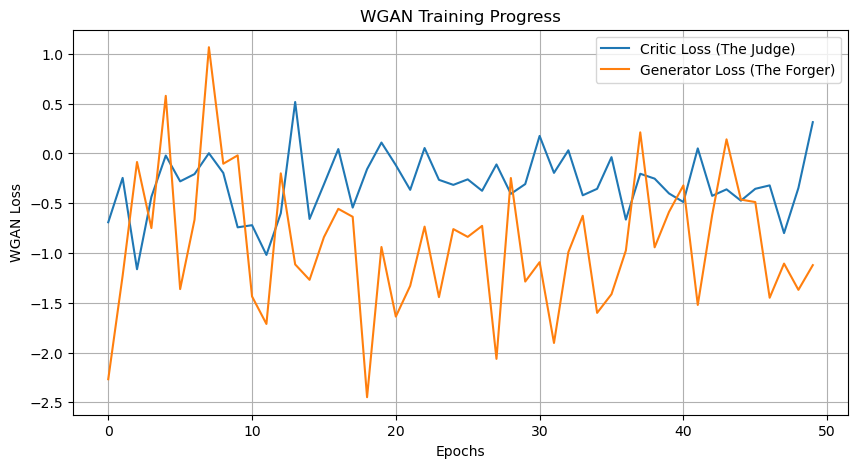

In [15]:
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Hyperparameters ---
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 50        # Enough to see it learning
LAMBDA_GP = 10     # Standard penalty weight for WGAN-GP

# --- Optimizers ---
# We use Adam, which is standard for WGANs
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

print(f"Starting Training for {EPOCHS} Epochs...")
loss_history_g = []
loss_history_c = []

for epoch in range(EPOCHS):
    for batch_idx, (real,) in enumerate(dataloader):
        
        # Move real data to GPU
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # ---------------------
        #  1. Train Critic
        # ---------------------
        # The Critic gets to practice 5 times for every 1 turn the Generator gets
        for _ in range(5): 
            noise = torch.randn(cur_batch_size, Z_DIM).to(device)
            fake = gen(noise) # Generate fake traffic
            
            # Get scores from Critic
            critic_real = critic(real)
            critic_fake = critic(fake)
            
            # Calculate Penalty (The function we defined in Step 2)
            gp = compute_gradient_penalty(critic, real, fake)
            
            # WGAN Loss: maximize (Real Score - Fake Score)
            # We minimize the negative of that
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
            
            opt_critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # ---------------------
        #  2. Train Generator
        # ---------------------
        noise = torch.randn(cur_batch_size, Z_DIM).to(device)
        fake = gen(noise)
        gen_fake = critic(fake)
        
        # Generator wants to Maximize the Critic's score for its fakes
        # Create a penalty for non-zero values (L1 Norm)
        sparsity_penalty = torch.mean(torch.abs(fake)) 
        
        # Add it to the loss (0.1 is the weight/strength)
        loss_gen = -torch.mean(gen_fake) + (0.1 * sparsity_penalty)
        
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
    # --- Logging ---
    loss_history_g.append(loss_gen.item())
    loss_history_c.append(loss_critic.item())
    
    if epoch % 5 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch [{epoch}/{EPOCHS}]  Loss D: {loss_critic.item():.4f}, Loss G: {loss_gen.item():.4f}")

print("Training Complete!")

# --- Visualize Training ---
plt.figure(figsize=(10,5))
plt.plot(loss_history_c, label='Critic Loss (The Judge)')
plt.plot(loss_history_g, label='Generator Loss (The Forger)')
plt.legend()
plt.title("WGAN Training Progress")
plt.xlabel("Epochs")
plt.ylabel("WGAN Loss")
plt.grid(True)
plt.show()

Metric     | Real Data       | Fake Data      
--------------------------------------------------
Mean       | -0.5023         | -0.5287        
Std        | 0.3000          | 0.2976         
Max        | 0.1905          | 0.2306         

Time Context Check:
Real Time Val: -0.48 (Normalized)
Fake Time Val: 0.63 (Normalized)


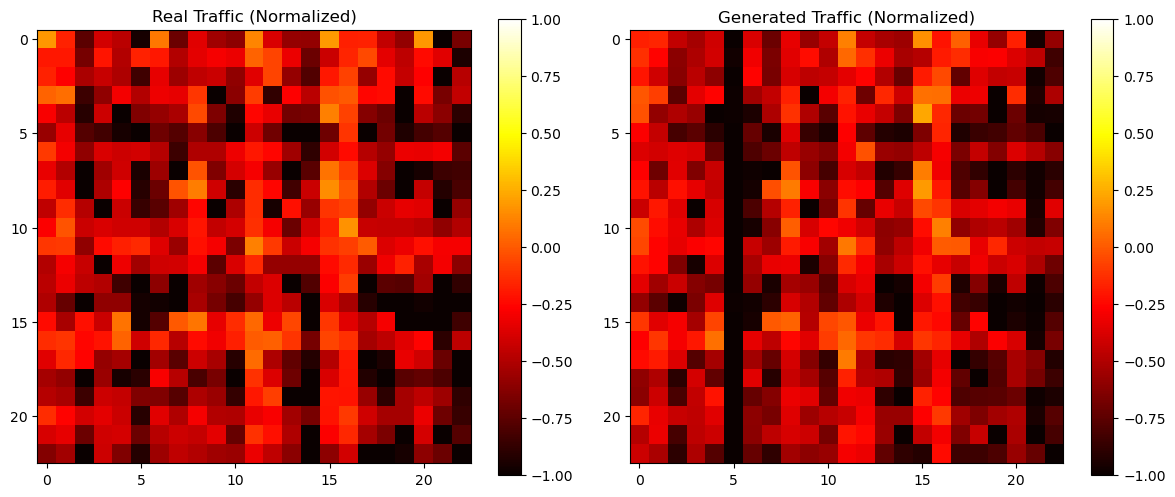

In [20]:

# --- Visualization & Statistics Code ---
gen.eval() 

# 1. Get a Real Sample
# We grab a batch and slice it
real_batch = next(iter(dataloader))[0] # Shape [64, 530]
real_time = real_batch[0, 0].item()    # First number is Time
real_traffic = real_batch[0, 1:]       # Rest is Traffic (529)
real_matrix = real_traffic.reshape(23, 23).numpy()

# 2. Generate a Fake Sample
with torch.no_grad():
    noise = torch.randn(1, Z_DIM).to(device)
    fake_output = gen(noise).cpu().numpy() # Shape [1, 530]
    
    fake_time = fake_output[0, 0]
    fake_traffic = fake_output[0, 1:]
    fake_matrix = fake_traffic.reshape(23, 23)

# 3. Calculate Statistics (On Traffic Only)
stats = {
    "Real": {
        "Mean": np.mean(real_matrix),
        "Std": np.std(real_matrix),
        "Max": np.max(real_matrix)
    },
    "Fake": {
        "Mean": np.mean(fake_matrix),
        "Std": np.std(fake_matrix),
        "Max": np.max(fake_matrix)
    }
}

# 4. Print Report
print(f"{'Metric':<10} | {'Real Data':<15} | {'Fake Data':<15}")
print("-" * 50)
for metric in ["Mean", "Std", "Max"]:
    print(f"{metric:<10} | {stats['Real'][metric]:<15.4f} | {stats['Fake'][metric]:<15.4f}")

print(f"\nTime Context Check:")
print(f"Real Time Val: {real_time:.2f} (Normalized)")
print(f"Fake Time Val: {fake_time:.2f} (Normalized)")

# 5. Plot Side-by-Side
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title(f"Real Traffic (Normalized)")
plt.imshow(real_matrix, cmap='hot', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title(f"Generated Traffic (Normalized)")
plt.imshow(fake_matrix, cmap='hot', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.tight_layout()
plt.show()

In [21]:
# 1. Save the Trained Model (The Brain)
torch.save(gen.state_dict(), "gan_generator.pth")
print("Saved 'gan_generator.pth' (The Model Weights)")

# 2. Generate the Synthetic Data
print("Generating synthetic dataset for Mininet...")
num_samples = 2000 
gen.eval()

with torch.no_grad():
    noise = torch.randn(num_samples, Z_DIM).to(device)
    # Get the raw output from the generator (Values are between -1 and 1)
    fake_output = gen(noise).cpu().numpy() # Shape: (2000, 530)

# --- CRITICAL FIX: Separate Time from Traffic ---
# Column 0 is Time. Columns 1 to 529 are Traffic.
fake_time_norm = fake_output[:, 0]    # Shape (2000,)
fake_traffic_norm = fake_output[:, 1:] # Shape (2000, 529)

# 3. Inverse Normalization (Back to Log Scale)
# We use the t_min and t_max variables we calculated in Cell 1
# Formula: x = ((y + 1) / 2) * (max - min) + min
fake_log_scale = ((fake_traffic_norm + 1) / 2) * (t_max - t_min) + t_min

# 4. Inverse Log (Back to Real Raw Values)
# Formula: exp(x) - 1
fake_traffic_raw = np.expm1(fake_log_scale)

# 5. Convert to Mbps (Approximation for Mininet)
# The GÉANT data is likely in Bytes/15min. 
# We need to scale it down so Mininet doesn't freeze.
# This division factor (1,000,000) keeps numbers in the 0-100 range.
fake_traffic_mbps = fake_traffic_raw / 1000000 

# Clip negatives (caused by math precision) and cap massive spikes at 100 Mbps
fake_traffic_mbps = np.clip(fake_traffic_mbps, 0, 100) 

# 6. Save to CSV
# We only save the TRAFFIC (529 cols) for Mininet, ignoring the Time column
df_final = pd.DataFrame(fake_traffic_mbps)
df_final.to_csv("synthetic_traffic.csv", index=False, header=False)

print(f"Saved 'synthetic_traffic.csv'")
print(f"File Shape: {df_final.shape} (Should be 2000 rows, 529 cols)")
print("Mininet is ready to read this file!")

Saved 'gan_generator.pth' (The Model Weights)
Generating synthetic dataset for Mininet...
Saved 'synthetic_traffic.csv'
File Shape: (2000, 529) (Should be 2000 rows, 529 cols)
Mininet is ready to read this file!


C:\Users\santh\AppData\Local\Temp\ipykernel_4920\3382811863.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_gen.load_state_dict(torch.load("gan_generator.pth"))


✅ Model loaded successfully from 'gan_generator.pth'
Generating validation sample...
----------------------------------------
VERIFICATION REPORT
----------------------------------------
Total Output Shape: (1, 530) (Should be 1, 530)
Traffic Shape:      (529,) (Should be 529)
Generated Time:     -0.3674 (Normalized)
Traffic Range:      [-1.0000, 0.2266]


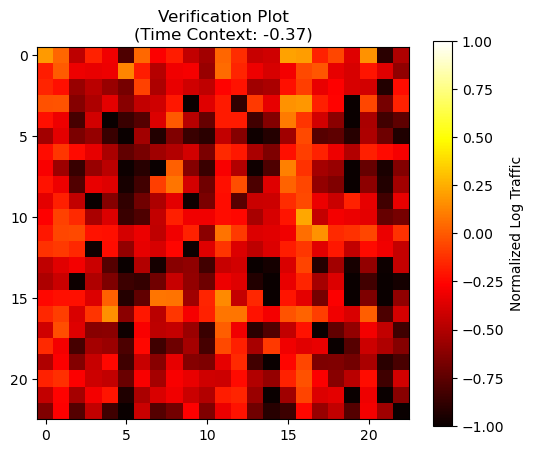

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-Define the Architecture (Must match EXACTLY) ---
Z_DIM = 100
DATA_DIM = 530  # <--- CRITICAL FIX: Changed from 529 to 530
HIDDEN_DIM = 128

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Z_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LayerNorm(HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM * 4),
            nn.LayerNorm(HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM * 4, DATA_DIM),
            nn.Tanh() 
        )

    def forward(self, x):
        return self.net(x)

# --- 2. Load the Saved Brain ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_gen = Generator().to(device)

try:
    # Changed path to local file (no /kaggle/input...)
    loaded_gen.load_state_dict(torch.load("gan_generator.pth"))
    loaded_gen.eval() # Set to "Test Mode"
    print("✅ Model loaded successfully from 'gan_generator.pth'")
except FileNotFoundError:
    print("❌ Error: File not found. Make sure you ran Cell 5 first!")

# --- 3. Generate Test Traffic ---
if 'loaded_gen' in locals():
    print("Generating validation sample...")
    with torch.no_grad():
        test_noise = torch.randn(1, Z_DIM).to(device)
        generated_data = loaded_gen(test_noise).cpu().numpy() # Shape is (1, 530)

    # --- 4. Separate Time and Traffic (The Fix) ---
    fake_time_val = generated_data[0, 0]      # The first number is Time
    fake_traffic_val = generated_data[0, 1:]  # The other 529 are Traffic

    # --- 5. Verify Output Statistics ---
    min_val = np.min(fake_traffic_val)
    max_val = np.max(fake_traffic_val)
    mean_val = np.mean(fake_traffic_val)

    print("-" * 40)
    print(f"VERIFICATION REPORT")
    print("-" * 40)
    print(f"Total Output Shape: {generated_data.shape} (Should be 1, 530)")
    print(f"Traffic Shape:      {fake_traffic_val.shape} (Should be 529)")
    print(f"Generated Time:     {fake_time_val:.4f} (Normalized)")
    print(f"Traffic Range:      [{min_val:.4f}, {max_val:.4f}]")

    # --- 6. Visual Check ---
    # Now we reshape ONLY the traffic part
    matrix = fake_traffic_val.reshape(23, 23)
    
    plt.figure(figsize=(6, 5))
    plt.title(f"Verification Plot\n(Time Context: {fake_time_val:.2f})")
    plt.imshow(matrix, cmap='hot', interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar(label='Normalized Log Traffic')
    plt.show()

In [24]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Save the Trained Model (The Brain)
torch.save(gen.state_dict(), "gan_generator.pth")
print("Saved 'gan_generator.pth' (The Model Weights)")

# 2. Generate the Synthetic Data
print("Generating synthetic dataset for Mininet...")
num_samples = 2000 
gen.eval()

with torch.no_grad():
    noise = torch.randn(num_samples, Z_DIM).to(device)
    # Get the raw output [2000 rows, 530 cols]
    fake_output = gen(noise).cpu().numpy() 

# --- STEP A: Separate Time and Traffic ---
# Drop the Time Column (Col 0)
fake_traffic_norm = fake_output[:, 1:] # Shape: (2000, 529)

# --- STEP B: The "Cookie Cutter" (Slice 23x23 -> 16x16) ---
# We need to reshape to matrix to slice correctly
# 1. Reshape to (Samples, 23, 23)
traffic_matrix_23 = fake_traffic_norm.reshape(num_samples, 23, 23)

# 2. Slice the top-left 16x16 (Matches your Fat-Tree Hosts)
traffic_matrix_16 = traffic_matrix_23[:, :16, :16]

# 3. Flatten back to rows (Samples, 256)
fake_traffic_16_flat = traffic_matrix_16.reshape(num_samples, -1)

print(f"Resized Traffic from {fake_traffic_norm.shape} to {fake_traffic_16_flat.shape}")

# --- STEP C: Inverse Normalization (On the 16x16 data) ---
# Formula: x = ((y + 1) / 2) * (max - min) + min
# Note: We use the same t_max/t_min because the scale of traffic is the same
fake_log_scale = ((fake_traffic_16_flat + 1) / 2) * (t_max - t_min) + t_min

# --- STEP D: Inverse Log & Mbps Conversion ---
fake_traffic_raw = np.expm1(fake_log_scale)

# Convert to Mbps and Clip
fake_traffic_mbps = fake_traffic_raw / 1000000 
fake_traffic_mbps = np.clip(fake_traffic_mbps, 0, 100) 

# --- STEP E: Save to CSV ---
df_final = pd.DataFrame(fake_traffic_mbps)
df_final.to_csv("synthetic_traffic_16hosts.csv", index=False, header=False)

print(f"Saved 'synthetic_traffic_16hosts.csv'")
print(f"Final Format: {df_final.shape} (2000 Rows, 256 Columns)")
print("✅ This file is now perfectly formatted for a 16-Host Mininet!")


Saved 'gan_generator.pth' (The Model Weights)
Generating synthetic dataset for Mininet...
Resized Traffic from (2000, 529) to (2000, 256)
Saved 'synthetic_traffic_16hosts.csv'
Final Format: (2000, 256) (2000 Rows, 256 Columns)
✅ This file is now perfectly formatted for a 16-Host Mininet!


🔍 INSPECTING: synthetic_traffic_16hosts.csv

📊 DATA STATISTICS:
   Shape: (2000, 256) (Rows, Cols)
   Minimum Value: 0.0000
   Maximum Value: 100.0000
   Mean Value:    0.0296

⚖️ VERDICT:
   ⚠️ The data is ALREADY DENORMALIZED (Values are large).
   -> Do NOT denormalize again, or it will explode to infinity.


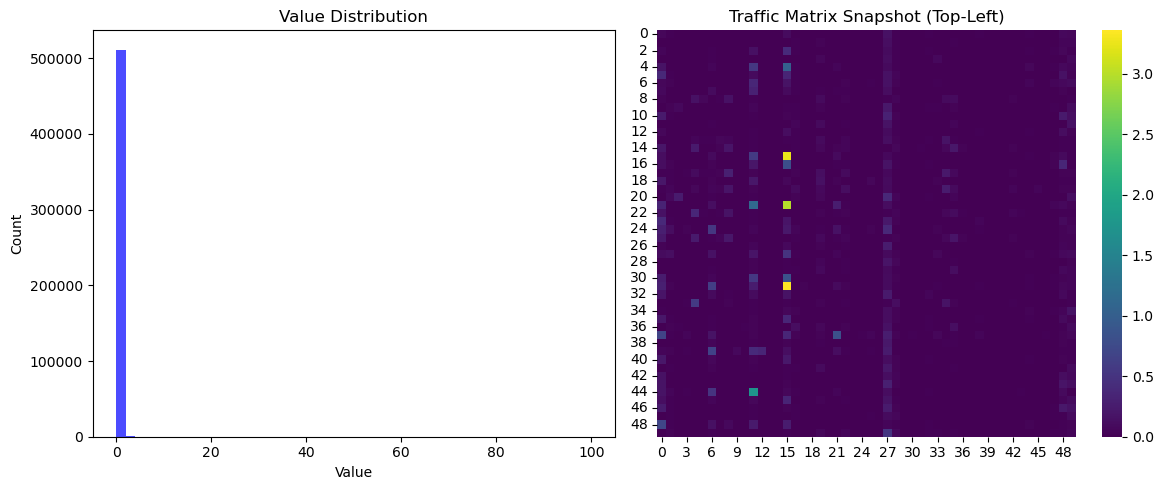

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
# Change this to the exact filename you are trying to use
FILENAME = "synthetic_traffic_16hosts.csv" 

print(f"🔍 INSPECTING: {FILENAME}")

try:
    # 1. Load the Data
    df = pd.read_csv(FILENAME, header=None)
    data = df.values
    
    # 2. Print Key Statistics
    print("\n📊 DATA STATISTICS:")
    print(f"   Shape: {data.shape} (Rows, Cols)")
    print(f"   Minimum Value: {data.min():.4f}")
    print(f"   Maximum Value: {data.max():.4f}")
    print(f"   Mean Value:    {data.mean():.4f}")
    
    # 3. The Verdict
    print("\n⚖️ VERDICT:")
    if data.min() >= -1.5 and data.max() <= 1.5:
        print("   ✅ The data is NORMALIZED (Range is approx -1 to 1).")
        print("   -> You MUST denormalize this before using it.")
    elif data.max() > 10.0:
        print("   ⚠️ The data is ALREADY DENORMALIZED (Values are large).")
    else:
        print("   ❓ The data is in an unknown range. Check the histogram below.")

    # 4. Visual Check (Heatmap & Histogram)
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Value Distribution")
    plt.xlabel("Value")
    plt.ylabel("Count")
    
    # Heatmap (First 50 rows, first 50 cols)
    plt.subplot(1, 2, 2)
    sns.heatmap(data[:50, :50], cmap='viridis')
    plt.title("Traffic Matrix Snapshot (Top-Left)")
    
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ Error: Could not find file '{FILENAME}'. Check the name!")

In [8]:
import pandas as pd
import numpy as np

# --- CONFIG ---
FILENAME = "synthetic_traffic_16hosts.csv"  # Ensure this matches your file

print(f"📊 Analyzing Traffic Distribution in {FILENAME}...")

try:
    # 1. Load Data
    df = pd.read_csv(FILENAME, header=None)
    data = df.values.flatten() # Flatten to 1D array for counting
    
    total_samples = len(data)
    print(f"   Total Data Points: {total_samples:,}")

    # 2. Define Ranges (0-10, 10-20 ... 100+)
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 999999]
    labels = [
        "0 - 10 Mbps", "10 - 20 Mbps", "20 - 30 Mbps", "30 - 40 Mbps", 
        "40 - 50 Mbps", "50 - 60 Mbps", "60 - 70 Mbps", "70 - 80 Mbps", 
        "80 - 90 Mbps", "90 - 100 Mbps", "🚨 > 100 Mbps (CONGESTION)"
    ]

    # 3. Count
    # specifically putting 'right=False' so 10.0 goes into 10-20, not 0-10
    categories = pd.cut(data, bins=bins, labels=labels, right=False)
    counts = categories.value_counts().sort_index()

    # 4. Print Table
    print("\n   | Range           | Count      | Percentage |")
    print("   |-----------------|------------|------------|")
    
    for label, count in counts.items():
        percentage = (count / total_samples) * 100
        # Highlight the interesting rows
        prefix = "   "
        if "CONGESTION" in label and count > 0:
            prefix = "🔥 " 
        elif "0 - 10" in label:
            prefix = "💤 "
            
        print(f"{prefix}| {label:<15} | {count:>10,} | {percentage:>9.2f}% |")

    # 5. The Verdict
    congestion_count = counts.iloc[-1]
    congestion_percent = (congestion_count / total_samples) * 100
    
    print("\n⚖️ VERDICT:")
    if congestion_percent < 0.1:
        print("❌ BORING DATA: Less than 0.1% of flows cause congestion.")
        print("   The Agent will sleep. You need to BOOST the traffic.")
    elif congestion_percent < 5.0:
        print("⚠️ OKAY DATA: Some congestion (1-5%), but mostly quiet.")
        print("   Consider multiplying all values by 1.5x or 2.0x.")
    else:
        print("✅ GOOD DATA: Enough congestion (>5%) for the Agent to learn.")

except FileNotFoundError:
    print(f"❌ Error: File {FILENAME} not found.")

📊 Analyzing Traffic Distribution in synthetic_traffic_16hosts.csv...
   Total Data Points: 512,000

   | Range           | Count      | Percentage |
   |-----------------|------------|------------|
💤 | 0 - 10 Mbps     |    511,936 |     99.99% |
   | 10 - 20 Mbps    |         29 |      0.01% |
   | 20 - 30 Mbps    |         14 |      0.00% |
   | 30 - 40 Mbps    |          7 |      0.00% |
   | 40 - 50 Mbps    |          1 |      0.00% |
   | 50 - 60 Mbps    |          2 |      0.00% |
   | 60 - 70 Mbps    |          1 |      0.00% |
   | 70 - 80 Mbps    |          0 |      0.00% |
   | 80 - 90 Mbps    |          0 |      0.00% |
💤 | 90 - 100 Mbps   |          0 |      0.00% |
🔥 | 🚨 > 100 Mbps (CONGESTION) |         10 |      0.00% |

⚖️ VERDICT:
❌ BORING DATA: Less than 0.1% of flows cause congestion.
   The Agent will sleep. You need to BOOST the traffic.


🐘 INJECTING ELEPHANT FLOWS INTO: synthetic_traffic_16hosts.csv
   ... Background noise clamped to 20 Mbps.
   ... Injecting Elephants (110-150 Mbps)...

📊 NEW DISTRIBUTION:
   Total Seconds Simulated: 2000
   Elephant Flows Injected: 301
   Congestion Events: 301
   💾 Saved to: synthetic_traffic_16hosts_ELEPHANTS.csv


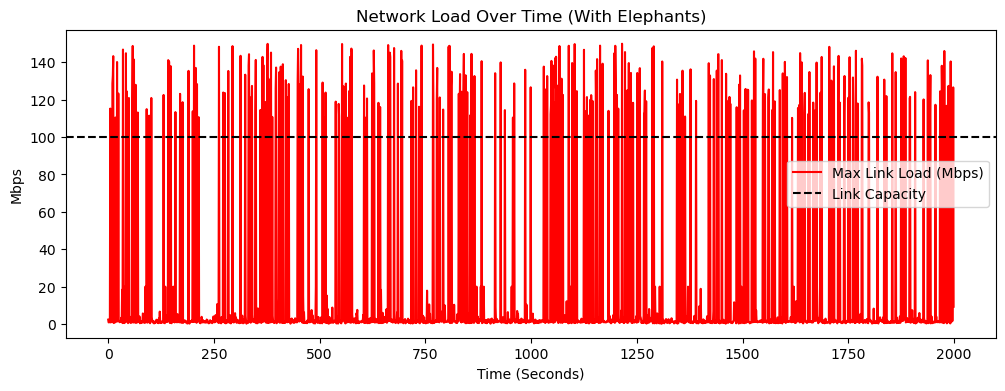

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# --- CONFIGURATION ---
INPUT_FILE = "synthetic_traffic_16hosts.csv"       # Your original WGAN output
OUTPUT_FILE = "synthetic_traffic_16hosts_ELEPHANTS.csv" # The new "Smart" file

# SIMULATION SETTINGS
NUM_HOSTS = 16
PROBABILITY_OF_ELEPHANT = 0.15  # 30% chance a row has an Elephant
ELEPHANT_SIZE_MIN = 110.0      # Min Mbps for Elephant (Congestion > 100)
ELEPHANT_SIZE_MAX = 150.0      # Max Mbps for Elephant

print(f"🐘 INJECTING ELEPHANT FLOWS INTO: {INPUT_FILE}")

# 1. Load Data
df = pd.read_csv(INPUT_FILE, header=None)
data = df.values
num_rows, num_cols = data.shape

# 2. The Logic: "Sniper Injection"
# We iterate through every second (row) of the simulation.
# We roll a dice. If it hits, we pick a random pair and make them HUGE.

boosted_data = data.copy()

# A. First, clamp the background noise so it stays small (Mice)
# We limit "normal" traffic to 20 Mbps so it doesn't interfere
boosted_data = np.clip(boosted_data, 0, 20.0) 

print("   ... Background noise clamped to 20 Mbps.")
print("   ... Injecting Elephants (110-150 Mbps)...")

elephant_count = 0

for i in range(num_rows):
    # Roll the dice: Should an Elephant appear at this second?
    if random.random() < PROBABILITY_OF_ELEPHANT:
        # Pick a Random Source and Destination
        # (Avoid src == dst)
        src = random.randint(0, NUM_HOSTS - 1)
        dst = random.randint(0, NUM_HOSTS - 1)
        while src == dst:
            dst = random.randint(0, NUM_HOSTS - 1)
            
        # Calculate the Column Index for this pair
        # Formula: col = src * NUM_HOSTS + dst
        col_idx = src * NUM_HOSTS + dst
        
        # Inject the Elephant!
        flow_size = random.uniform(ELEPHANT_SIZE_MIN, ELEPHANT_SIZE_MAX)
        boosted_data[i, col_idx] = flow_size
        
        elephant_count += 1

# 3. Stats
print("\n📊 NEW DISTRIBUTION:")
print(f"   Total Seconds Simulated: {num_rows}")
print(f"   Elephant Flows Injected: {elephant_count}")
print(f"   Congestion Events: {np.sum(boosted_data > 100)}")

# 4. Save
pd.DataFrame(boosted_data).to_csv(OUTPUT_FILE, header=False, index=False)
print(f"   💾 Saved to: {OUTPUT_FILE}")

# 5. Visual Check (First 1000 flows)
plt.figure(figsize=(12, 4))
plt.plot(boosted_data.max(axis=1), label="Max Link Load (Mbps)", color='red')
plt.axhline(y=100, color='black', linestyle='--', label="Link Capacity")
plt.title("Network Load Over Time (With Elephants)")
plt.xlabel("Time (Seconds)")
plt.ylabel("Mbps")
plt.legend()
plt.show()

In [11]:
import pandas as pd
import numpy as np

# --- CONFIG ---
# Make sure this matches the filename you just created
FILENAME = "synthetic_traffic_16hosts_ELEPHANTS.csv"

print(f"📊 Analyzing Traffic Distribution in {FILENAME}...")

try:
    # 1. Load Data
    df = pd.read_csv(FILENAME, header=None)
    data = df.values.flatten() # Flatten 2D matrix to 1D array
    
    total_samples = len(data)
    print(f"   Total Data Points: {total_samples:,}")
    print(f"   Max Value Found:   {data.max():.2f} Mbps")

    # 2. Define Ranges (Standard vs. Elephant)
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 999999]
    labels = [
        "0 - 10 Mbps", "10 - 20 Mbps", "20 - 30 Mbps", "30 - 40 Mbps", 
        "40 - 50 Mbps", "50 - 60 Mbps", "60 - 70 Mbps", "70 - 80 Mbps", 
        "80 - 90 Mbps", "90 - 100 Mbps", "🚨 100-120 Mbps (Mild)", "🔥 120-150 Mbps (HEAVY)", "💀 > 150 Mbps (EXTREME)"
    ]

    # 3. Count
    categories = pd.cut(data, bins=bins, labels=labels, right=False)
    counts = categories.value_counts().sort_index()

    # 4. Print Table
    print("\n   | Range                  | Count      | Percentage |")
    print("   |------------------------|------------|------------|")
    
    for label, count in counts.items():
        percentage = (count / total_samples) * 100
        
        # Define Prefix Icons
        prefix = "   "
        if "HEAVY" in label or "EXTREME" in label:
            prefix = "🐘 "  # Elephant Flow!
        elif "Mild" in label:
            prefix = "⚠️ "
        elif "0 - 10" in label:
            prefix = "💤 "
            
        print(f"{prefix}| {label:<22} | {count:>10,} | {percentage:>9.4f}% |")

    # 5. The Verdict
    congestion_count = counts.iloc[-3:].sum() # Sum of >100, >120, >150
    congestion_percent = (congestion_count / total_samples) * 100
    
    print("\n⚖️ VERDICT:")
    if congestion_percent < 0.01:
        print("❌ FAILED: No Elephant Flows found.")
        print("   Did you run the injector script? The network is too quiet.")
    elif congestion_percent < 1.0:
        print("✅ PERFECT: You have 'Rare but Severe' congestion.")
        print("   This mimics real life (99% quiet, 1% panic). Ideally suited for RL.")
    else:
        print("⚠️  CHAOS MODE: More than 1% of the network is on fire.")
        print("   This is a very hard difficulty setting, but good for stress testing.")

except FileNotFoundError:
    print(f"❌ Error: File {FILENAME} not found. Did you run the Injector script?")

📊 Analyzing Traffic Distribution in synthetic_traffic_16hosts_ELEPHANTS.csv...
   Total Data Points: 512,000
   Max Value Found:   149.91 Mbps

   | Range                  | Count      | Percentage |
   |------------------------|------------|------------|
💤 | 0 - 10 Mbps            |    511,635 |   99.9287% |
   | 10 - 20 Mbps           |         29 |    0.0057% |
   | 20 - 30 Mbps           |         35 |    0.0068% |
   | 30 - 40 Mbps           |          0 |    0.0000% |
   | 40 - 50 Mbps           |          0 |    0.0000% |
   | 50 - 60 Mbps           |          0 |    0.0000% |
   | 60 - 70 Mbps           |          0 |    0.0000% |
   | 70 - 80 Mbps           |          0 |    0.0000% |
   | 80 - 90 Mbps           |          0 |    0.0000% |
💤 | 90 - 100 Mbps          |          0 |    0.0000% |
⚠️ | 🚨 100-120 Mbps (Mild)  |         83 |    0.0162% |
🐘 | 🔥 120-150 Mbps (HEAVY) |        218 |    0.0426% |
🐘 | 💀 > 150 Mbps (EXTREME) |          0 |    0.0000% |

⚖️ VERDICT:
✅ PERFE

🦌 INJECTING MULTI-TIER FLOWS INTO: synthetic_traffic_16hosts.csv
   ... Background noise clamped to 0-10 Mbps.
   ... Injecting 'Deer' (40-90 Mbps) and 'Elephants' (110-150 Mbps)...

📊 INJECTION REPORT:
   Total Seconds: 2000
   🦌 Mid-Tier Flows (Deer):     321 (Fills the gap)
   🐘 Top-Tier Flows (Elephant): 110 (Causes Congestion)
   💾 Saved to: synthetic_traffic_16hosts_REALISTIC.csv


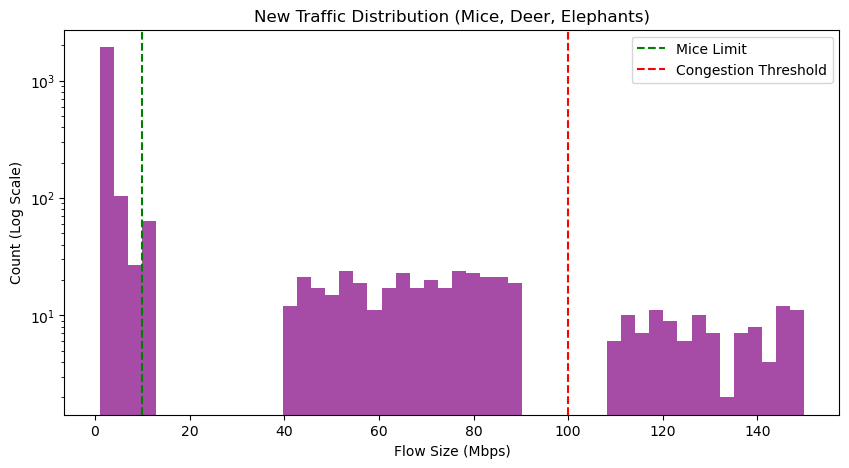

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# --- CONFIGURATION ---
INPUT_FILE = "synthetic_traffic_16hosts.csv"
OUTPUT_FILE = "synthetic_traffic_16hosts_REALISTIC.csv"

# SIMULATION SETTINGS
NUM_HOSTS = 16
NUM_FLOWS_PER_ROW = 530 # Roughly 16x16 pairs + overhead

# PROBABILITIES (Per Second)
PROB_ELEPHANT = 0.05   # 5% chance of a massive spike (120-150 Mbps)
PROB_DEER     = 0.15   # 15% chance of medium traffic (40-90 Mbps)

print(f"🦌 INJECTING MULTI-TIER FLOWS INTO: {INPUT_FILE}")

# 1. Load Data
df = pd.read_csv(INPUT_FILE, header=None)
data = df.values
num_rows, num_cols = data.shape

# 2. Base Noise (Mice)
# Clamp the WGAN output to be quiet (0-10 Mbps)
# This preserves the "pattern" but keeps it low.
realistic_data = np.clip(data, 0, 10.0)

print("   ... Background noise clamped to 0-10 Mbps.")
print("   ... Injecting 'Deer' (40-90 Mbps) and 'Elephants' (110-150 Mbps)...")

counts = {"Mice": 0, "Deer": 0, "Elephant": 0}

for i in range(num_rows):
    # A. Inject Deer (Medium Flows)
    # We inject slightly more of these
    if random.random() < PROB_DEER:
        # Pick a random pair
        col_idx = random.randint(0, num_cols - 1)
        # Generate flow size: 40 to 90 Mbps
        flow_size = random.uniform(40.0, 90.0)
        realistic_data[i, col_idx] = flow_size
        counts["Deer"] += 1
        
    # B. Inject Elephants (Heavy Flows)
    # These override Deer if they happen on the same spot
    if random.random() < PROB_ELEPHANT:
        col_idx = random.randint(0, num_cols - 1)
        # Generate flow size: 110 to 150 Mbps
        flow_size = random.uniform(110.0, 150.0)
        realistic_data[i, col_idx] = flow_size
        counts["Elephant"] += 1

# 3. Stats Check
total_events = counts['Deer'] + counts['Elephant']
print("\n📊 INJECTION REPORT:")
print(f"   Total Seconds: {num_rows}")
print(f"   🦌 Mid-Tier Flows (Deer):     {counts['Deer']} (Fills the gap)")
print(f"   🐘 Top-Tier Flows (Elephant): {counts['Elephant']} (Causes Congestion)")

# 4. Save
pd.DataFrame(realistic_data).to_csv(OUTPUT_FILE, header=False, index=False)
print(f"   💾 Saved to: {OUTPUT_FILE}")

# 5. Visual Distribution Check
plt.figure(figsize=(10, 5))
flat_data = realistic_data.flatten()
# Filter out 0s for cleaner plot
nonzero_data = flat_data[flat_data > 1.0] 

plt.hist(nonzero_data, bins=50, color='purple', alpha=0.7)
plt.title("New Traffic Distribution (Mice, Deer, Elephants)")
plt.xlabel("Flow Size (Mbps)")
plt.ylabel("Count (Log Scale)")
plt.yscale('log') # Log scale helps see the small counts of Elephants
plt.axvline(x=10, color='green', linestyle='--', label="Mice Limit")
plt.axvline(x=100, color='red', linestyle='--', label="Congestion Threshold")
plt.legend()
plt.show()

🎚️ MIXING TRAFFIC:
   🐁 Mice: 65.0% | 🐇 Rabbits: 27.0% | 🦌 Deer: 5.0% | 🐘 Elephants: 3.0%

💾 Saved New Mix to: Dataset/Synthesis/synthetic_traffic_16hosts_FINAL1.csv

📊 TRAFFIC REPORT:
   | Tier       | Range (Mbps) | Count      | Actual % | Target % |
   |------------|--------------|------------|----------|----------|
   | 🐁 Mice    | 0 - 8        |    332,800 |   65.00% |    65.0% |
   | 🐇 Rabbits | 8 - 45       |    138,240 |   27.00% |    27.0% |
   | 🦌 Deer    | 45 - 95      |     25,601 |    5.00% |     5.0% |
   | 🐘 Elephants| 95 - 140    |     15,359 |    3.00% |     3.0% |


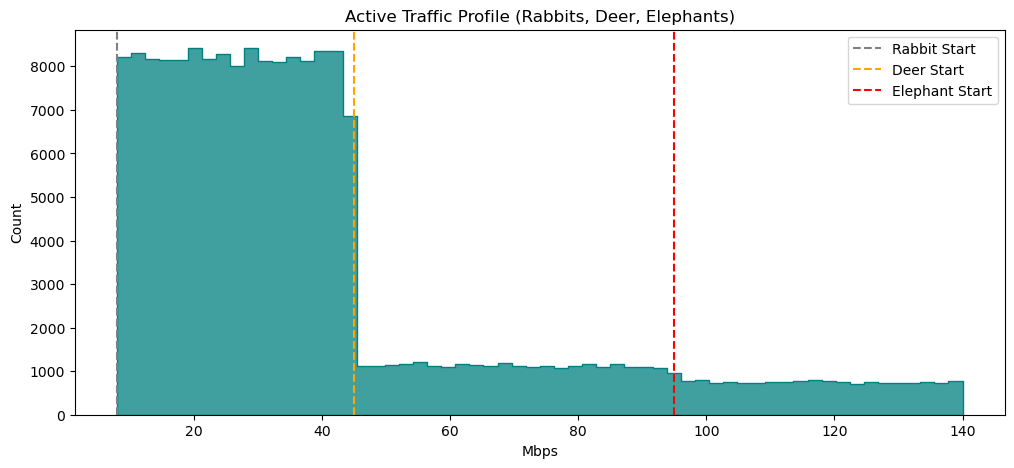

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 🎛️ CONFIGURATION: PLAY WITH THESE NUMBERS ---
# Make sure these add up to 1.0 (100%)
PCT_MICE     = 0.65  # 85% Background Noise (0-8 Mbps)
PCT_RABBITS  = 0.27   # 12% Normal Active (8-45 Mbps)
PCT_DEER     = 0.05  # 2.5% Heavy Load (45-95 Mbps)
PCT_ELEPHANT = 0.03  # 0.5% Congestion (95-140 Mbps)

# File Paths
INPUT_FILE = "Dataset/Synthesis/synthetic_traffic_16hosts.csv"
OUTPUT_FILE = "Dataset/Synthesis/synthetic_traffic_16hosts_FINAL1.csv"

# --- CHECK MATH ---
total_pct = PCT_MICE + PCT_RABBITS + PCT_DEER + PCT_ELEPHANT
if abs(total_pct - 1.0) > 0.0001:
    print(f"⚠️ WARNING: Your percentages sum to {total_pct:.2f}, not 1.0!")
    print("   The script might behave unexpectedly. Please fix the config.")

print(f"🎚️ MIXING TRAFFIC:")
print(f"   🐁 Mice: {PCT_MICE*100}% | 🐇 Rabbits: {PCT_RABBITS*100}% | 🦌 Deer: {PCT_DEER*100}% | 🐘 Elephants: {PCT_ELEPHANT*100}%")

try:
    # 1. Load Data
    df = pd.read_csv(INPUT_FILE, header=None)
    data = df.values.flatten()
    original_shape = df.values.shape
    
    # 2. CALCULATE RANKS
    argsort_indices = np.argsort(data)
    ranks = np.zeros_like(data)
    ranks[argsort_indices] = np.arange(len(data)) / len(data)

    # 3. APPLY DISTRIBUTION
    new_data = np.zeros_like(data)
    
    # Calculate Cutoff Points
    cut_rabbit = PCT_MICE
    cut_deer   = PCT_MICE + PCT_RABBITS
    cut_elephant = PCT_MICE + PCT_RABBITS + PCT_DEER
    
    # --- MICE (0 - 8 Mbps) ---
    mask_mice = ranks < cut_rabbit
    new_data[mask_mice] = np.random.uniform(0, 8, size=np.sum(mask_mice))
    
    # --- RABBITS (8 - 45 Mbps) ---
    mask_rabbits = (ranks >= cut_rabbit) & (ranks < cut_deer)
    new_data[mask_rabbits] = np.random.uniform(8, 45, size=np.sum(mask_rabbits))
    
    # --- DEER (45 - 95 Mbps) ---
    mask_deer = (ranks >= cut_deer) & (ranks < cut_elephant)
    new_data[mask_deer] = np.random.uniform(45, 95, size=np.sum(mask_deer))
    
    # --- ELEPHANTS (95 - 140 Mbps) ---
    mask_elephants = ranks >= cut_elephant
    new_data[mask_elephants] = np.random.uniform(95, 140, size=np.sum(mask_elephants))

    # 4. Save
    final_matrix = new_data.reshape(original_shape)
    pd.DataFrame(final_matrix).to_csv(OUTPUT_FILE, header=False, index=False)
    print(f"\n💾 Saved New Mix to: {OUTPUT_FILE}")

    # 5. DISTRIBUTION CHECK
    print("\n📊 TRAFFIC REPORT:")
    total = len(new_data)
    
    # Define exact ranges for counting
    c_mice = np.sum(new_data < 8)
    c_rabbit = np.sum((new_data >= 8) & (new_data < 45))
    c_deer = np.sum((new_data >= 45) & (new_data < 95))
    c_elephant = np.sum(new_data >= 95)
    
    print(f"   | Tier       | Range (Mbps) | Count      | Actual % | Target % |")
    print(f"   |------------|--------------|------------|----------|----------|")
    print(f"   | 🐁 Mice    | 0 - 8        | {c_mice:>10,} | {c_mice/total*100:>7.2f}% | {PCT_MICE*100:>7.1f}% |")
    print(f"   | 🐇 Rabbits | 8 - 45       | {c_rabbit:>10,} | {c_rabbit/total*100:>7.2f}% | {PCT_RABBITS*100:>7.1f}% |")
    print(f"   | 🦌 Deer    | 45 - 95      | {c_deer:>10,} | {c_deer/total*100:>7.2f}% | {PCT_DEER*100:>7.1f}% |")
    print(f"   | 🐘 Elephants| 95 - 140    | {c_elephant:>10,} | {c_elephant/total*100:>7.2f}% | {PCT_ELEPHANT*100:>7.1f}% |")

    # 6. VISUALIZATION
    plt.figure(figsize=(12, 5))
    # Filter > 8 Mbps to see the active tiers clearly
    sns.histplot(new_data[new_data > 8], bins=60, color='teal', element="step")
    plt.title("Active Traffic Profile (Rabbits, Deer, Elephants)")
    plt.xlabel("Mbps")
    plt.ylabel("Count")
    
    # Draw Lines
    plt.axvline(8, color='gray', linestyle='--', label="Rabbit Start")
    plt.axvline(45, color='orange', linestyle='--', label="Deer Start")
    plt.axvline(95, color='red', linestyle='--', label="Elephant Start")
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"❌ Error: Input file '{INPUT_FILE}' not found.")

📊 Analyzing Traffic Distribution in Dataset/Synthesis/synthetic_traffic_16hosts_FINAL1.csv...
   Total Data Points: 512,000
   Max Value Found:   140.00 Mbps

   | Range                  | Count      | Percentage |
   |------------------------|------------|------------|
🐁 | 0-10 (Mice)            |    340,273 |   66.4596% |
   | 10-20                  |     37,355 |    7.2959% |
   | 20-30                  |     37,465 |    7.3174% |
   | 30-40                  |     37,139 |    7.2537% |
🦌 | 40-50 (Deer)           |     21,353 |    4.1705% |
   | 50-60                  |      5,250 |    1.0254% |
   | 60-70                  |      5,181 |    1.0119% |
   | 70-80                  |      5,005 |    0.9775% |
   | 80-90                  |      5,129 |    1.0018% |
   | 90-100                 |      4,246 |    0.8293% |
⚠️ | 100-120 (Mild)         |      6,913 |    1.3502% |
🐘 | 120-150 (ELEPHANT)     |      6,691 |    1.3068% |
🐘 | > 150 (Extreme)        |          0 |    0.0000% |


C:\Users\santh\AppData\Local\Temp\ipykernel_14308\3893015474.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette=colors)


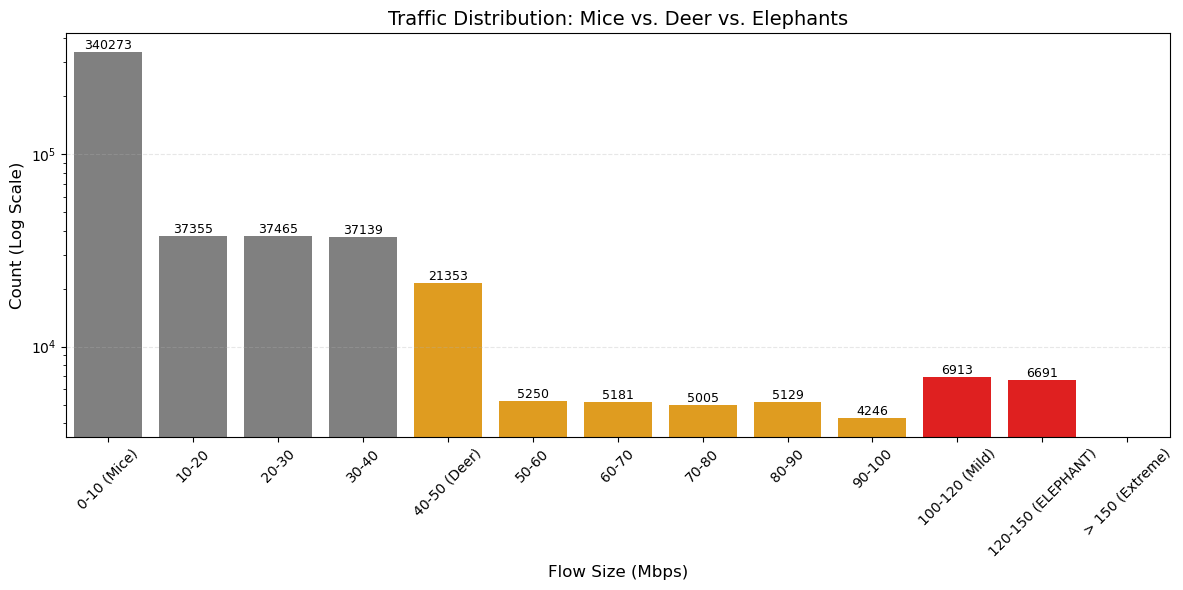


⚖️ VERDICT:
   🦌 Mid-Tier Traffic (Deer): 46164 samples
   🐘 High-Tier Traffic (Elephants): 6691 samples
✅ SUCCESS: You have a healthy ecosystem of Mice, Deer, and Elephants!


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
# Make sure this matches the file you just created with the Smart Booster
FILENAME = "Dataset/Synthesis/synthetic_traffic_16hosts_FINAL1.csv"

print(f"📊 Analyzing Traffic Distribution in {FILENAME}...")

try:
    # 1. Load Data
    df = pd.read_csv(FILENAME, header=None)
    data = df.values.flatten() # Flatten to 1D array
    
    total_samples = len(data)
    print(f"   Total Data Points: {total_samples:,}")
    print(f"   Max Value Found:   {data.max():.2f} Mbps")

    # 2. Define Ranges (Mice, Deer, Elephants)
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 999999]
    labels = [
        "0-10 (Mice)", "10-20", "20-30", "30-40", 
        "40-50 (Deer)", "50-60", "60-70", "70-80", 
        "80-90", "90-100", "100-120 (Mild)", "120-150 (ELEPHANT)", "> 150 (Extreme)"
    ]

    # 3. Count
    categories = pd.cut(data, bins=bins, labels=labels, right=False)
    counts = categories.value_counts().sort_index()

    # 4. Print Table
    print("\n   | Range                  | Count      | Percentage |")
    print("   |------------------------|------------|------------|")
    
    for label, count in counts.items():
        percentage = (count / total_samples) * 100
        
        # Define Prefix Icons
        prefix = "   "
        if "ELEPHANT" in label or "Extreme" in label:
            prefix = "🐘 "
        elif "Deer" in label:
            prefix = "🦌 "
        elif "Mild" in label:
            prefix = "⚠️ "
        elif "Mice" in label:
            prefix = "🐁 "
            
        print(f"{prefix}| {label:<22} | {count:>10,} | {percentage:>9.4f}% |")

    # 5. Plot the Graph
    plt.figure(figsize=(12, 6))
    
    # Create colors for bars
    colors = ['gray'] * 4 + ['orange'] * 6 + ['red'] * 3
    
    # Bar Chart (Log Scale for Y-axis to see the small counts)
    ax = sns.barplot(x=counts.index, y=counts.values, palette=colors)
    plt.yscale('log') # Log scale because Mice are 99%
    
    plt.title("Traffic Distribution: Mice vs. Deer vs. Elephants", fontsize=14)
    plt.xlabel("Flow Size (Mbps)", fontsize=12)
    plt.ylabel("Count (Log Scale)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add text labels on top of bars
    for i, v in enumerate(counts.values):
        if v > 0:
            ax.text(i, v, f"{v}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # 6. Verdict
    elephants = counts.iloc[-2:].sum()
    deer = counts.iloc[4:10].sum()
    print("\n⚖️ VERDICT:")
    print(f"   🦌 Mid-Tier Traffic (Deer): {deer} samples")
    print(f"   🐘 High-Tier Traffic (Elephants): {elephants} samples")
    
    if elephants > 0 and deer > 0:
        print("✅ SUCCESS: You have a healthy ecosystem of Mice, Deer, and Elephants!")
    elif elephants == 0:
        print("❌ FAIL: No Elephants found. Boost logic might be too weak.")
    else:
        print("⚠️ WARNING: No Deer found. The jump from 0 to 100 is too steep.")

except FileNotFoundError:
    print(f"❌ Error: File {FILENAME} not found. Did you run the Smart Boost script?")